#Group 6

#Title: Noise-Robust Speech Signal Processing: Enhancing Speech-to-Text Model Performance in Noisy Environments through Advanced Feature Engineering.



In [ ]:
import os
import glob
import librosa
import numpy as np
import pandas as pd

data_paths = [
    "F:/Project/LibriSpeech/Clean_data",  # Clean data path
    "F:/Project/LibriSpeech/Noisy_data"   # Noisy data path
]

def read_transcriptions(transcript_file):
    transcriptions = set() 
    with open(transcript_file, 'r') as file:
        for line in file:
            parts = line.strip().split(" ", 1)  
            if len(parts) == 2:
                file_name = parts[0]
                transcriptions.add(file_name)
    return transcriptions

# Extracting MFCC features
def extract_mfcc(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)  
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=19)  
    return np.mean(mfcc, axis=1) 

def extract_additional_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=None) 
    
    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    
    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    
    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    
    # Spectral Flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)
    spectral_flatness_mean = np.mean(spectral_flatness)
    
    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    
    # RMS Energy
    rms_energy = librosa.feature.rms(y=audio)
    rms_energy_mean = np.mean(rms_energy)
    
    return [spectral_centroid_mean, spectral_rolloff_mean, spectral_bandwidth_mean, spectral_flatness_mean, zero_crossing_rate_mean, rms_energy_mean]

def process_audio_files_in_folder(folder_path, label, feature_data):
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"Processing folder: {subfolder_path}")
            transcript_file = None
            for txt_file in glob.glob(os.path.join(subfolder_path, "*.trans.txt")):
                transcript_file = txt_file
                break

            if transcript_file:
                print(f"Transcript file found: {transcript_file}")
                transcriptions = read_transcriptions(transcript_file)

                for flac_file in glob.glob(os.path.join(subfolder_path, "*.flac")):
                    file_name = os.path.splitext(os.path.basename(flac_file))[0]

                    if file_name in transcriptions:
                        mfcc_features = extract_mfcc(flac_file)
                        additional_features = extract_additional_features(flac_file)
                        feature_data.append([file_name] + list(mfcc_features) + additional_features + [label])
                    else:
                        print(f"No transcription found for FLAC file: {flac_file}")
            else:
                print(f"No transcript file found in subfolder: {subfolder_path}")

def process_data(data_paths):
    feature_data = []  

    for data_path in data_paths:
        label = "clean" if "Clean_data" in data_path else "noisy"
        print(f"Processing {label} data in: {data_path}")
        for main_folder in os.listdir(data_path):
            main_folder_path = os.path.join(data_path, main_folder)
            if os.path.isdir(main_folder_path):
                process_audio_files_in_folder(main_folder_path, label, feature_data)

    columns = ['File Name'] + [f'MFCC_{i+1}' for i in range(13)] + \
              ['Spectral_Centroid', 'Spectral_Rolloff', 'Spectral_Bandwidth', 
               'Spectral_Flatness', 'Zero_Crossing_Rate', 'RMS_Energy', 'Label']
    df = pd.DataFrame(feature_data, columns=columns)

    df.to_csv("F:/Project/LibriSpeech/features_data_main.csv", index=False)
    print("Features saved to CSV file.")

process_data(data_paths)

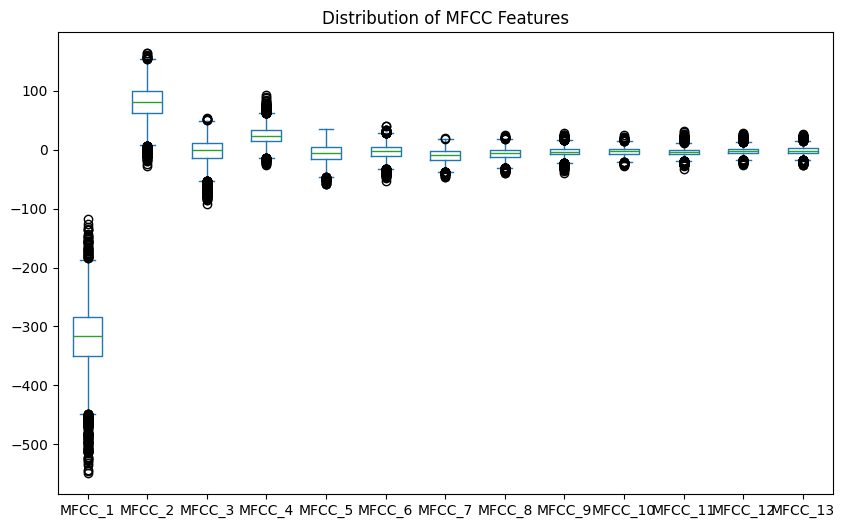

In [ ]:
#Distribution of MFCC Features

import pandas as pd
import matplotlib.pyplot as plt

feature_df = pd.read_csv('features_data_main.csv')

mfcc_columns = [col for col in feature_df.columns if 'MFCC' in col]

feature_df[mfcc_columns].plot(kind='box', figsize=(10, 6), title='Distribution of MFCC Features')

plt.show()

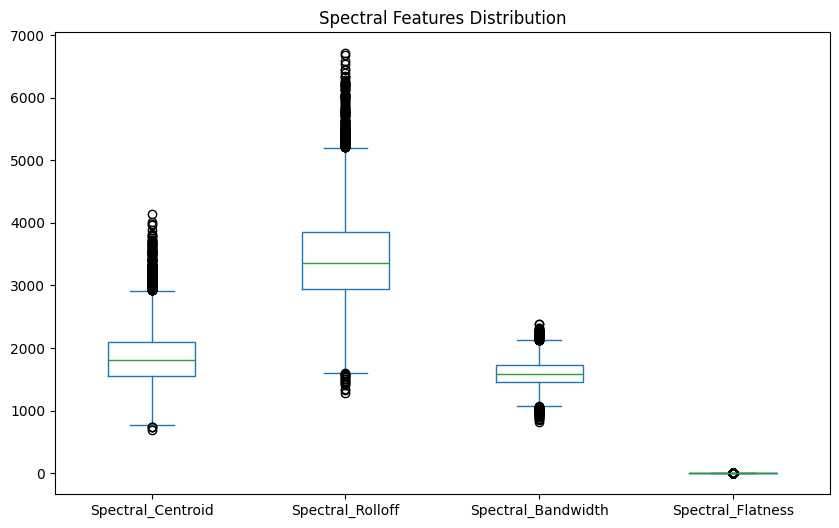

In [ ]:
# Spectral features Distribution
spectral_features = ['Spectral_Centroid', 'Spectral_Rolloff', 'Spectral_Bandwidth', 'Spectral_Flatness']
feature_df[spectral_features].plot(kind='box', figsize=(10, 6), title='Spectral Features Distribution')
plt.show()

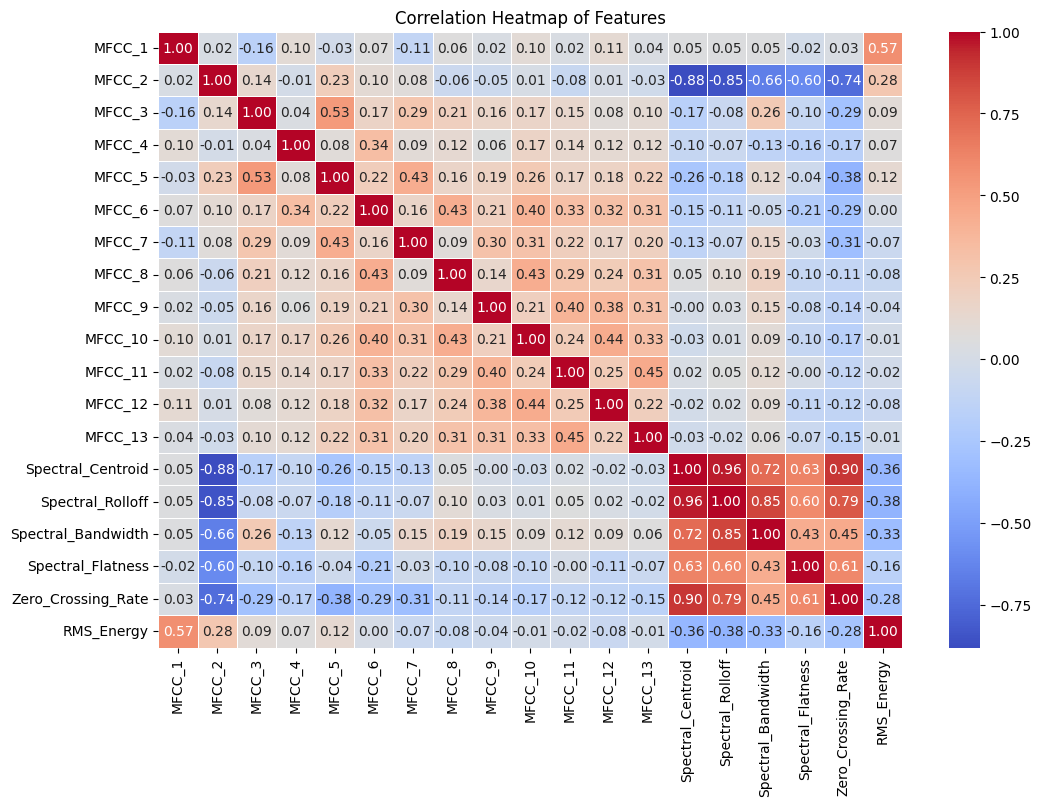

In [ ]:
# Correlation Heatmap of Features

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = feature_df.select_dtypes(include=['number', 'float64', 'int64'])

corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

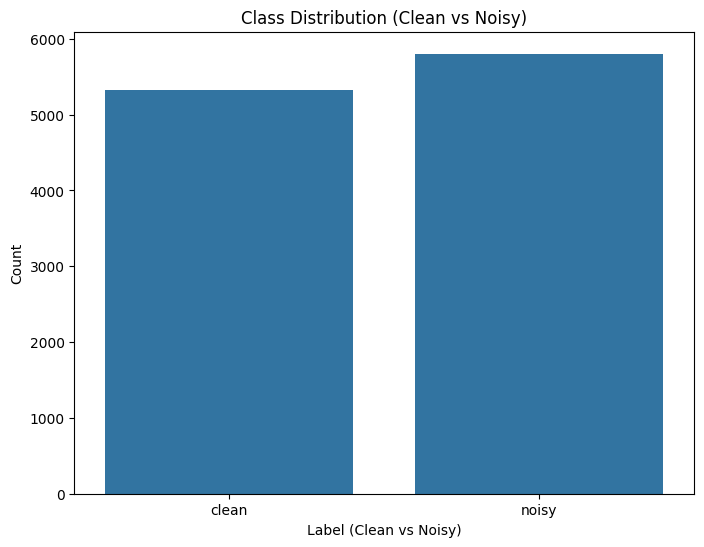

In [79]:
# Plotting class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=feature_df)
plt.title('Class Distribution (Clean vs Noisy)')
plt.xlabel('Label (Clean vs Noisy)')
plt.ylabel('Count')
plt.show()

# data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Extract features and labels
X = feature_df.drop(columns=['File Name', 'Label'])  
y = feature_df['Label']

# Normalize/Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("\nClass distribution in the training set:")
print(y_train.value_counts())

if 'noisy' in y_train.value_counts().index and 'clean' in y_train.value_counts().index:
    X_train_resampled, y_train_resampled = resample(X_train[y_train == 'noisy'], y_train[y_train == 'noisy'],
                                                   replace=True, n_samples=X_train[y_train == 'clean'].shape[0],
                                                   random_state=42)

    X_train_balanced = np.vstack((X_train[y_train == 'clean'], X_train_resampled))
    y_train_balanced = np.hstack((y_train[y_train == 'clean'], y_train_resampled))
    print("\nResampling completed. Balanced class distribution in training set:")
    print(np.unique(y_train_balanced, return_counts=True))
else:
    print("Class distribution is already balanced in the training set.")


Class distribution in the training set:
Label
noisy    4642
clean    4258
Name: count, dtype: int64

Resampling completed. Balanced class distribution in training set:
(array(['clean', 'noisy'], dtype=object), array([4258, 4258], dtype=int64))


# Baseline Model – SVM

Cross-Validation Accuracy Scores:  [0.66901408 0.67645332 0.69406929 0.6846741  0.65590135]
Mean Accuracy: 0.6760
Standard Deviation: 0.0131
Classification Report:
               precision    recall  f1-score   support

       clean       0.66      0.69      0.67      1065
       noisy       0.70      0.67      0.69      1161

    accuracy                           0.68      2226
   macro avg       0.68      0.68      0.68      2226
weighted avg       0.68      0.68      0.68      2226

Confusion Matrix:
 [[734 331]
 [380 781]]
Accuracy: 0.6806
Precision: 0.7023
Recall: 0.6727
F1-Score: 0.6872
ROC AUC: 0.7217


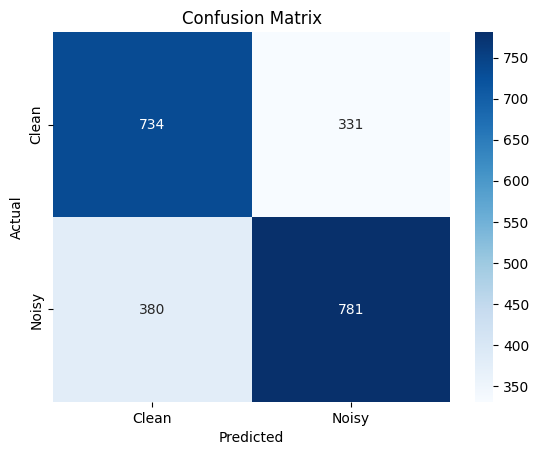

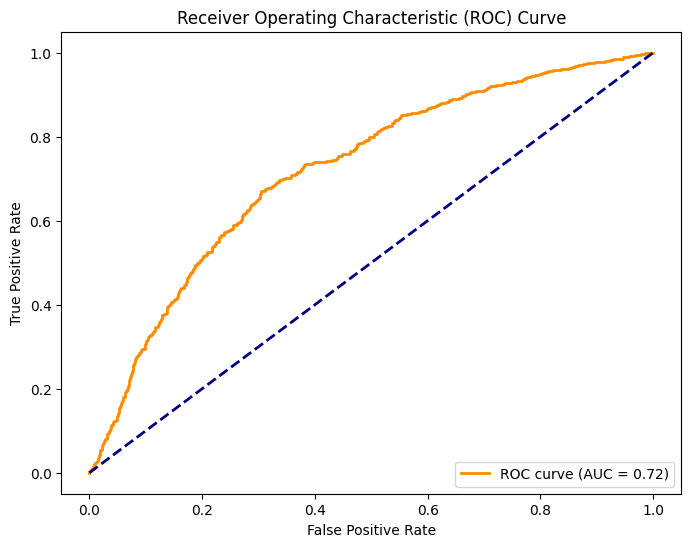

Model saved as svm_linear_model.pkl


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  

# Training SVM Model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

# Cross-validation using 5-folds
cv_scores = cross_val_score(svm_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores: ", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

y_pred = svm_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', pos_label='noisy')
recall = recall_score(y_test, y_pred, average='binary', pos_label='noisy')
f1 = f1_score(y_test, y_pred, average='binary', pos_label='noisy')

roc_auc = roc_auc_score(y_test, svm_model.decision_function(X_test))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Noisy'], yticklabels=['Clean', 'Noisy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, svm_model.decision_function(X_test), pos_label='noisy')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

model_filename = 'svm_linear_model.pkl'
joblib.dump(svm_model, model_filename)
print(f"Model saved as {model_filename}")

# Hyperparameter Tuning

Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-Validation Accuracy Scores:  [0.67402616 0.81892973 0.77125585 0.67402616 0.81810765 0.76867238
 0.67578755 0.93365553 0.87341635 0.67578755 0.93236377 0.8723596
 0.67637461 0.96688659 0.91181373 0.67637461 0.96676915 0.91087428]
Mean Accuracy: 0.8110
Standard Deviation: 0.1105
Accuracy: 0.9672
Precision: 0.9848
Recall: 0.9518
F1-Score: 0.9680
ROC AUC: 0.9931


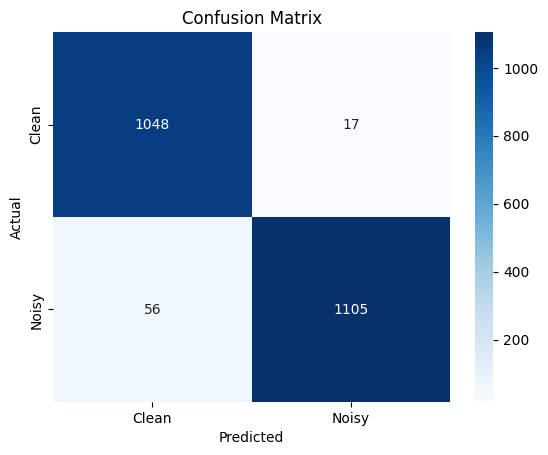

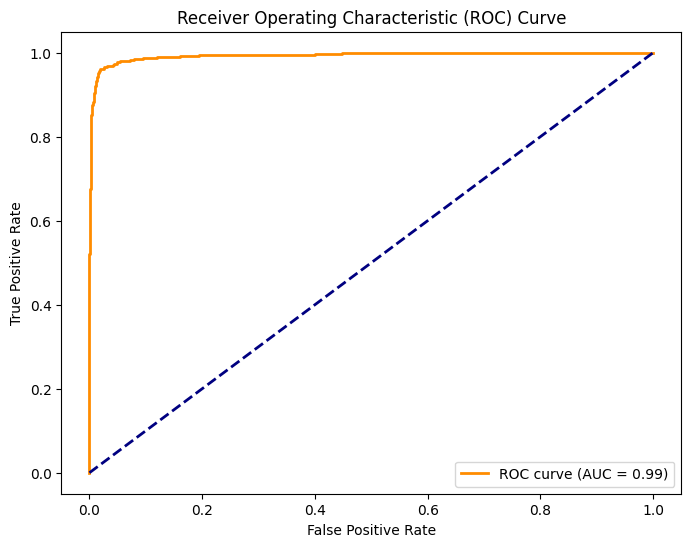

Best Model saved as svm_best_model.pkl


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters found: ", grid_search.best_params_)

svm_best_model = grid_search.best_estimator_
cv_scores = grid_search.cv_results_['mean_test_score']

print("Cross-Validation Accuracy Scores: ", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

y_pred_best = svm_best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='binary', pos_label='noisy')
recall = recall_score(y_test, y_pred_best, average='binary', pos_label='noisy')
f1 = f1_score(y_test, y_pred_best, average='binary', pos_label='noisy')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

roc_auc = roc_auc_score(y_test, svm_best_model.decision_function(X_test))
print(f"ROC AUC: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Noisy'], yticklabels=['Clean', 'Noisy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, svm_best_model.decision_function(X_test), pos_label='noisy')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

import joblib
model_filename = 'svm_best_model.pkl'
joblib.dump(svm_best_model, model_filename)
print(f"Best Model saved as {model_filename}")

In [87]:
# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Classification Report:
               precision    recall  f1-score   support

       clean       0.95      0.98      0.97      1065
       noisy       0.98      0.95      0.97      1161

    accuracy                           0.97      2226
   macro avg       0.97      0.97      0.97      2226
weighted avg       0.97      0.97      0.97      2226

Confusion Matrix:
 [[1048   17]
 [  56 1105]]


# Advanced Feature Engineering (RFE and PCA)

Classification Report with PCA:
               precision    recall  f1-score   support

       clean       0.57      0.63      0.60      1065
       noisy       0.63      0.57      0.60      1161

    accuracy                           0.60      2226
   macro avg       0.60      0.60      0.60      2226
weighted avg       0.60      0.60      0.60      2226

Accuracy (PCA): 0.5997
Precision (PCA): 0.6288
Recall (PCA): 0.5676
F1-Score (PCA): 0.5967
ROC AUC (PCA): 0.6220


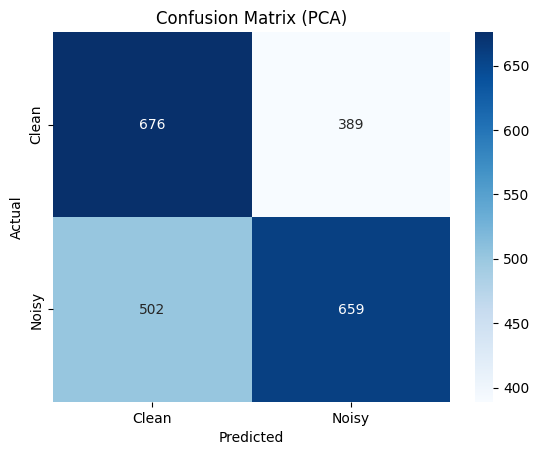

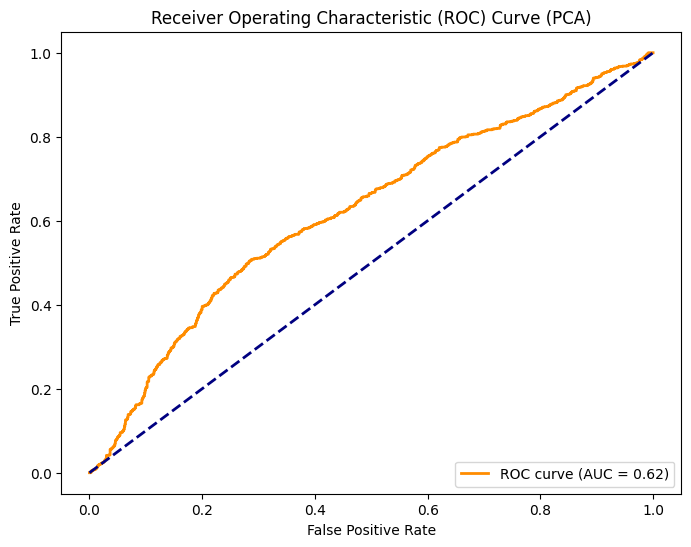

Cross-Validation Accuracy Scores for PCA: [0.59683099 0.59953024 0.61421022 0.59541985 0.59130945]
Mean Accuracy for PCA: 0.5995
Standard Deviation for PCA: 0.0078
Classification Report with RFE:
               precision    recall  f1-score   support

       clean       0.63      0.67      0.65      1065
       noisy       0.68      0.64      0.66      1161

    accuracy                           0.65      2226
   macro avg       0.66      0.66      0.65      2226
weighted avg       0.66      0.65      0.66      2226

Accuracy (RFE): 0.6550
Precision (RFE): 0.6785
Recall (RFE): 0.6434
F1-Score (RFE): 0.6605
ROC AUC (RFE): 0.7056


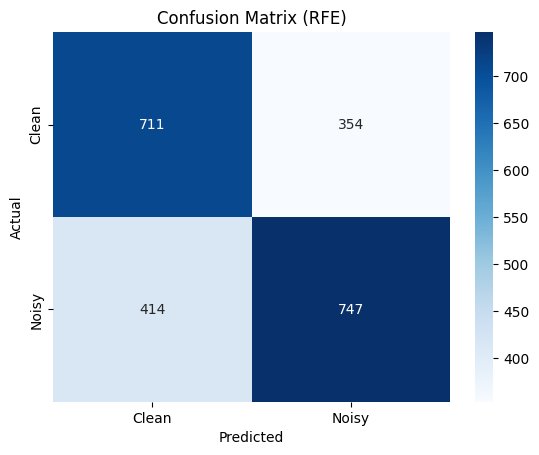

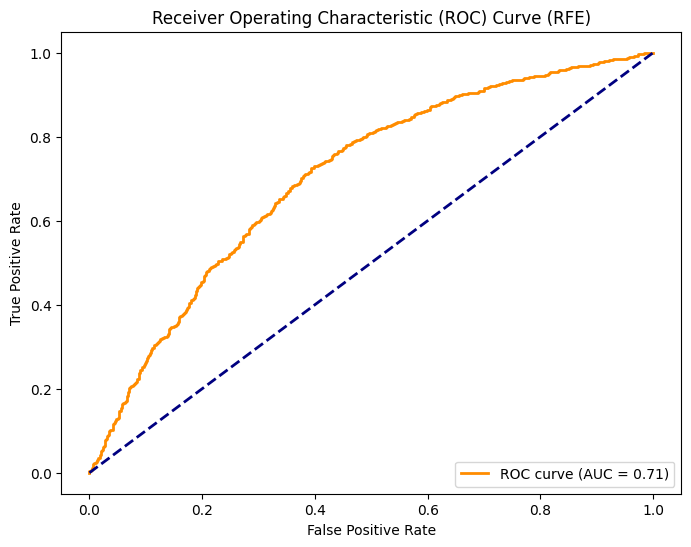

Cross-Validation Accuracy Scores for RFE: [0.65551643 0.67410452 0.66294774 0.66529654 0.63358779]
Mean Accuracy for RFE: 0.6583
Standard Deviation for RFE: 0.0137


In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

# PCA for Dimensionality Reduction
pca = PCA(n_components=10) 
X_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test)

# RFE for Feature Selection
svm_rfe = SVC(kernel='linear', random_state=42)
rfe = RFE(svm_rfe, n_features_to_select=10) 
X_train_rfe = rfe.fit_transform(X_train_balanced, y_train_balanced)
X_test_rfe = rfe.transform(X_test)

# Train SVM with PCA features
svm_model_pca = SVC(kernel='linear', random_state=42)
svm_model_pca.fit(X_train_pca, y_train_balanced)
y_pred_pca = svm_model_pca.predict(X_test_pca)

# Classification Report for PCA
print("Classification Report with PCA:\n", classification_report(y_test, y_pred_pca))

# Calculate Accuracy, Precision, Recall, F1-Score for PCA
accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca, average='binary', pos_label='noisy')
recall_pca = recall_score(y_test, y_pred_pca, average='binary', pos_label='noisy')
f1_pca = f1_score(y_test, y_pred_pca, average='binary', pos_label='noisy')

# Metrics for PCA model
print(f"Accuracy (PCA): {accuracy_pca:.4f}")
print(f"Precision (PCA): {precision_pca:.4f}")
print(f"Recall (PCA): {recall_pca:.4f}")
print(f"F1-Score (PCA): {f1_pca:.4f}")

# ROC AUC for PCA
roc_auc_pca = roc_auc_score(y_test, svm_model_pca.decision_function(X_test_pca))
print(f"ROC AUC (PCA): {roc_auc_pca:.4f}")

# Confusion Matrix for PCA
conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Noisy'], yticklabels=['Clean', 'Noisy'])
plt.title('Confusion Matrix (PCA)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for PCA
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test, svm_model_pca.decision_function(X_test_pca), pos_label='noisy')
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca, tpr_pca, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_pca:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (PCA)')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation for PCA
cv_scores_pca = cross_val_score(svm_model_pca, X_train_pca, y_train_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores for PCA:", cv_scores_pca)
print(f"Mean Accuracy for PCA: {cv_scores_pca.mean():.4f}")
print(f"Standard Deviation for PCA: {cv_scores_pca.std():.4f}")

# Train SVM with RFE features
svm_model_rfe = SVC(kernel='linear', random_state=42)
svm_model_rfe.fit(X_train_rfe, y_train_balanced)
y_pred_rfe = svm_model_rfe.predict(X_test_rfe)

# Classification Report with RFE
print("Classification Report with RFE:\n", classification_report(y_test, y_pred_rfe))

# Calculate Accuracy, Precision, Recall, F1-Score for RFE
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
precision_rfe = precision_score(y_test, y_pred_rfe, average='binary', pos_label='noisy')
recall_rfe = recall_score(y_test, y_pred_rfe, average='binary', pos_label='noisy')
f1_rfe = f1_score(y_test, y_pred_rfe, average='binary', pos_label='noisy')

# Metrics for RFE model
print(f"Accuracy (RFE): {accuracy_rfe:.4f}")
print(f"Precision (RFE): {precision_rfe:.4f}")
print(f"Recall (RFE): {recall_rfe:.4f}")
print(f"F1-Score (RFE): {f1_rfe:.4f}")

# ROC AUC for RFE
roc_auc_rfe = roc_auc_score(y_test, svm_model_rfe.decision_function(X_test_rfe))
print(f"ROC AUC (RFE): {roc_auc_rfe:.4f}")

# Confusion Matrix for RFE
conf_matrix_rfe = confusion_matrix(y_test, y_pred_rfe)
sns.heatmap(conf_matrix_rfe, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Noisy'], yticklabels=['Clean', 'Noisy'])
plt.title('Confusion Matrix (RFE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for RFE
fpr_rfe, tpr_rfe, thresholds_rfe = roc_curve(y_test, svm_model_rfe.decision_function(X_test_rfe), pos_label='noisy')
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfe, tpr_rfe, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rfe:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (RFE)')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation for RFE
cv_scores_rfe = cross_val_score(svm_model_rfe, X_train_rfe, y_train_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores for RFE:", cv_scores_rfe)
print(f"Mean Accuracy for RFE: {cv_scores_rfe.mean():.4f}")
print(f"Standard Deviation for RFE: {cv_scores_rfe.std():.4f}")

In [ ]:
import joblib

joblib.dump(svm_model_pca, 'svm_model_pca.pkl')
joblib.dump(pca, 'pca_transformer.pkl')
joblib.dump(svm_model_rfe, 'svm_model_rfe.pkl')
joblib.dump(rfe, 'rfe_transformer.pkl')
print("Models and transformers saved successfully!")

Models and transformers saved successfully!


# Polynomial Features

SVM Model with Polynomial Features Classification Report:
               precision    recall  f1-score   support

       clean       0.81      0.87      0.84      1065
       noisy       0.87      0.82      0.84      1161

    accuracy                           0.84      2226
   macro avg       0.84      0.84      0.84      2226
weighted avg       0.84      0.84      0.84      2226

Accuracy (Polynomial): 0.8419
Precision (Polynomial): 0.8714
Recall (Polynomial): 0.8174
F1-Score (Polynomial): 0.8436
ROC AUC (Polynomial): 0.9209


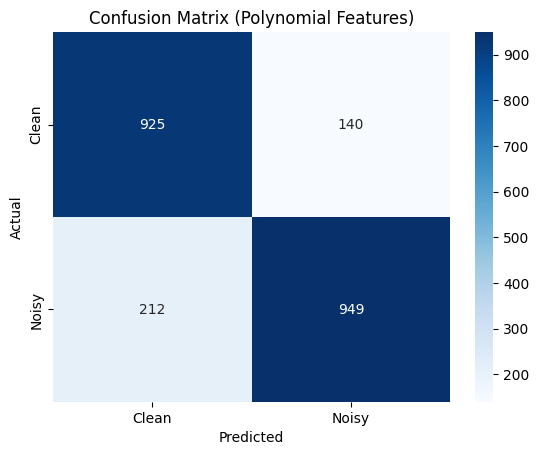

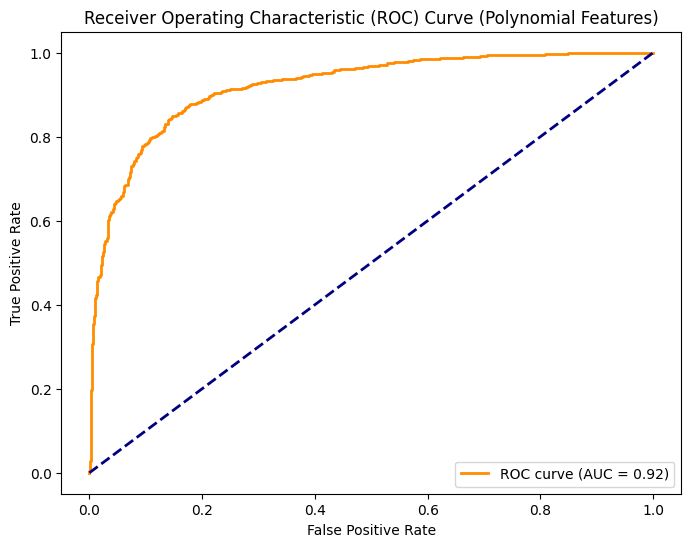

Cross-Validation Accuracy Scores for Polynomial Features: [0.83861502 0.86083382 0.83910746 0.85731063 0.85613623]
Mean Accuracy for Polynomial Features: 0.8504
Standard Deviation for Polynomial Features: 0.0095


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

# Adding polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_balanced)

svm_poly_model = SVC(kernel='linear', random_state=42)
svm_poly_model.fit(X_train_poly, y_train_balanced)

y_pred_poly = svm_poly_model.predict(poly.transform(X_test))

print("SVM Model with Polynomial Features Classification Report:\n", classification_report(y_test, y_pred_poly))

accuracy_poly = accuracy_score(y_test, y_pred_poly)
precision_poly = precision_score(y_test, y_pred_poly, average='binary', pos_label='noisy')
recall_poly = recall_score(y_test, y_pred_poly, average='binary', pos_label='noisy')
f1_poly = f1_score(y_test, y_pred_poly, average='binary', pos_label='noisy')

print(f"Accuracy (Polynomial): {accuracy_poly:.4f}")
print(f"Precision (Polynomial): {precision_poly:.4f}")
print(f"Recall (Polynomial): {recall_poly:.4f}")
print(f"F1-Score (Polynomial): {f1_poly:.4f}")

roc_auc_poly = roc_auc_score(y_test, svm_poly_model.decision_function(poly.transform(X_test)))
print(f"ROC AUC (Polynomial): {roc_auc_poly:.4f}")

conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(conf_matrix_poly, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Noisy'], yticklabels=['Clean', 'Noisy'])
plt.title('Confusion Matrix (Polynomial Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr_poly, tpr_poly, thresholds_poly = roc_curve(y_test, svm_poly_model.decision_function(poly.transform(X_test)), pos_label='noisy')
plt.figure(figsize=(8, 6))
plt.plot(fpr_poly, tpr_poly, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_poly:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Polynomial Features)')
plt.legend(loc='lower right')
plt.show()

cv_scores_poly = cross_val_score(svm_poly_model, X_train_poly, y_train_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores for Polynomial Features:", cv_scores_poly)
print(f"Mean Accuracy for Polynomial Features: {cv_scores_poly.mean():.4f}")
print(f"Standard Deviation for Polynomial Features: {cv_scores_poly.std():.4f}")

In [ ]:
import joblib

joblib.dump(svm_poly_model, 'svm_poly_model.pkl')
joblib.dump(poly, 'polynomial_transformer.pkl')
print("SVM model and Polynomial Features transformer saved successfully!")

SVM model and Polynomial Features transformer saved successfully!
